<a href="https://colab.research.google.com/github/sayakpaul/Adventures-in-TensorFlow-Lite/blob/master/MobileDet_Conversion_TFLite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we will see how to convert a pre-trained [MobileDet](https://arxiv.org/abs/2004.14525) model to TensorFlow Lite (using the latest converter). As the MobileDet model we are going to be using was trained in TensorFlow 1 we first need to generate a TensorFlow Lite compatible graph file following the instructions from [here](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/running_on_mobile_tensorflowlite.md). 

**WIP**: Include direct TFLite model download links so that users can directly try them out. 

In [1]:
#@title Initial setup
# Because MobileDet is based out of TensorFlow 1
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

!git clone --quiet https://github.com/tensorflow/models.git

TensorFlow 1.x selected.
1.15.2


In [ ]:
#@title Install the TFOD API
%%bash
pip install --upgrade pip
cd models/research
# Compile protos.
protoc object_detection/protos/*.proto --python_out=.
# Install TensorFlow Object Detection API.
cp object_detection/packages/tf1/setup.py .
python -m pip install --use-feature=2020-resolver .

## Export to TFLite compatible graph

In [2]:
#@title Fetch the checkpoints
#@markdown Model checkpoints are listed [here](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf1_detection_zoo.md). 
mobiledet_checkpoint_name = "ssd_mobiledet_cpu_coco" #@param ["ssd_mobiledet_cpu_coco", "ssd_mobiledet_edgetpu_coco", "ssd_mobiledet_dsp_coco"]

checkpoint_dict = {
    "ssd_mobiledet_cpu_coco": "http://download.tensorflow.org/models/object_detection/ssdlite_mobiledet_cpu_320x320_coco_2020_05_19.tar.gz",
    "ssd_mobiledet_edgetpu_coco": "http://download.tensorflow.org/models/object_detection/ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19.tar.gz",
    "ssd_mobiledet_dsp_coco": "http://download.tensorflow.org/models/object_detection/ssdlite_mobiledet_dsp_320x320_coco_2020_05_19.tar.gz"
}

folder_name_dict = {
    "ssd_mobiledet_cpu_coco": "ssdlite_mobiledet_cpu_320x320_coco_2020_05_19",
    "ssd_mobiledet_edgetpu_coco": "ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19",
    "ssd_mobiledet_dsp_coco": "ssdlite_mobiledet_dsp_320x320_coco_2020_05_19"
}

checkpoint_selected = checkpoint_dict[mobiledet_checkpoint_name]
folder_name = folder_name_dict[mobiledet_checkpoint_name]

# Get the pre-trained MobileDet checkpoints
!rm -rf folder_name
!wget -q $checkpoint_selected -O checkpoints.tar.gz
!tar -xvf checkpoints.tar.gz

ssdlite_mobiledet_cpu_320x320_coco_2020_05_19/
ssdlite_mobiledet_cpu_320x320_coco_2020_05_19/model.ckpt-400000.data-00000-of-00001
ssdlite_mobiledet_cpu_320x320_coco_2020_05_19/model.ckpt-400000.index
ssdlite_mobiledet_cpu_320x320_coco_2020_05_19/model.ckpt-400000.meta
ssdlite_mobiledet_cpu_320x320_coco_2020_05_19/tflite_graph.pbtxt
ssdlite_mobiledet_cpu_320x320_coco_2020_05_19/tflite_graph.pb
ssdlite_mobiledet_cpu_320x320_coco_2020_05_19/pipeline.config
ssdlite_mobiledet_cpu_320x320_coco_2020_05_19/model.tflite


**Note** that the checkpoint bundles already come with a TFLite compatible graphs. But the purpose of this notebook is to provide you with a way to adapt the tools for your own models. 

In [ ]:
#@title Export a TFLite compatible model graph
#@markdown - For **DSP** & **EdgeTPU** provide `fp32` or `uint8` to the `trained_checkpoint_prefix` and `pipeline_config_path` arguments.
precision = "uint8" #@param ["fp32", "uint8"]

if "dsp" in folder_name or "edgetpu" in folder_name:
    !python /content/models/research/object_detection/export_tflite_ssd_graph.py \
        --pipeline_config_path=$folder_name/$precision/pipeline.config \
        --trained_checkpoint_prefix=$folder_name/$precision/model.ckpt-400000 \
        --output_directory=$folder_name/$precision \
        --add_postprocessing_op=true
    print("======Graph generated========")
    !ls -lh $folder_name/$precision/*.pb
else:
    !python /content/models/research/object_detection/export_tflite_ssd_graph.py \
        --pipeline_config_path=$folder_name/pipeline.config \
        --trained_checkpoint_prefix=$folder_name/model.ckpt-400000 \
        --output_directory=$folder_name \
        --add_postprocessing_op=true
    print("======Graph generated========")
    !ls -lh $folder_name/*.pb

In each of the respective model folders the graph file would be generated with this name - `tflite_graph.pb`. You can see the size of the graph in the output of the above code block (it should appear below `======Graph generated========`). 

We now need to switch to TensorFlow 2 runtime. We need to restart our Colab runtime first. 

## Export to TFLite

In [1]:
#@title Initial setup
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

import os

2.3.0


In [2]:
#@title Download the COCO `train2014` dataset and subsample 100 images for it
#@markdown **Note**: To run this, please first uncomment the code.
#@markdown Additionally, you can skip this step and download a tar'd version of the subsampled images from [here](https://github.com/sayakpaul/Adventures-in-TensorFlow-Lite/releases/download/v0.9.0/train_samples_coco.tar.gz) by running `wget -q https://github.com/sayakpaul/Adventures-in-TensorFlow-Lite/releases/download/v0.9.0/train_samples_coco.tar.gz`.
# from imutils import paths
# import random
# import shutil
# import tqdm
# import os

# !wget -q http://images.cocodataset.org/zips/train2014.zip
# !unzip -qq train2014.zip

# train_image_path = list(paths.list_images("/content/train2014"))
# random.shuffle(train_image_path)

# hundred_images = train_image_path[:100]

# !mkdir train_samples

# for image_path in tqdm.tqdm(hundred_images):
#     image_filename = image_path.split("/")[-1]
#     dst_filename = os.path.join("train_samples", image_filename)
#     shutil.copy2(image_path, dst_filename)
# !wget -q https://github.com/sayakpaul/Adventures-in-TensorFlow-Lite/releases/download/v0.9.0/train_samples_coco.tar.gz

In [ ]:
#@markdown If you downloaded the tar file then uncomment and run this code block.
# !tar -xvf train_samples_coco.tar.gz

In [26]:
#@title Select model to quantize
model_checkpoint_name = "ssd_mobiledet_dsp_coco_uint8" #@param ["ssd_mobiledet_cpu_coco", "ssd_mobiledet_edgetpu_coco_fp32", "ssd_mobiledet_edgetpu_coco_uint8", "ssd_mobiledet_dsp_coco_fp32", "ssd_mobiledet_dsp_coco_uint8"]
model_dict = {
    "ssd_mobiledet_cpu_coco": "ssdlite_mobiledet_cpu_320x320_coco_2020_05_19/tflite_graph.pb",
    "ssd_mobiledet_edgetpu_coco_fp32": "ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19/fp32/tflite_graph.pb",
    "ssd_mobiledet_edgetpu_coco_uint8": "ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19/uint8/tflite_graph.pb",
    "ssd_mobiledet_dsp_coco_fp32": "/content/ssdlite_mobiledet_dsp_320x320_coco_2020_05_19/fp32/tflite_graph.pb",
    "ssd_mobiledet_dsp_coco_uint8": "/content/ssdlite_mobiledet_dsp_320x320_coco_2020_05_19/uint8/tflite_graph.pb"
}
model_to_be_quantized = model_dict[model_checkpoint_name]
if os.path.getsize(model_to_be_quantized) > 0:
    print(f"We are quantizing: {model_dict[model_checkpoint_name]}")
else:
    print("Model not found!")

We are quantizing: /content/ssdlite_mobiledet_dsp_320x320_coco_2020_05_19/uint8/tflite_graph.pb


In [6]:
#@title Integer quantization requires a representative dataset
# Load up the image paths as a TensorFlow dataset
rep_ds = tf.data.Dataset.list_files("train_samples/*.jpg")
HEIGHT, WIDTH = 320, 320

def representative_dataset_gen():
    for image_path in rep_ds:
        img = tf.io.read_file(image_path)
        img = tf.io.decode_image(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        resized_img = tf.image.resize(img, (HEIGHT, WIDTH))
        resized_img = resized_img[tf.newaxis, :]
        yield [resized_img]

As the `.pb` file we generated in the earlier step is a frozen graph, we need to use [`tf.compat.v1.lite.TFLiteConverter.from_frozen_graph`](https://www.tensorflow.org/api_docs/python/tf/compat/v1/lite/TFLiteConverter) to convert it to TFLite. 

In [27]:
#@title Quantize and serialize (`uint8` are WIP)
#@markdown For `uint8` variants don't use `fp16` and `dr` quantization strategies. This is because the base models were trained to take advantage EdgeTPU and DSP accelerators. These only support integer models.  

#@markdown If you selected `int8` then please be patient. It takes time. 

original_precision = "uint8" #@param ["uint8", "fp32", "regular"]
quantization_strategy = "int8" #@param ["dr", "fp16", "int8"]

converter = tf.compat.v1.lite.TFLiteConverter.from_frozen_graph(
    graph_def_file=model_to_be_quantized, 
    input_arrays=['normalized_input_image_tensor'],
    output_arrays=['TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3'],
    input_shapes={'normalized_input_image_tensor': [1, 320, 320, 3]}
)
converter.allow_custom_ops = True

if original_precision=="uint8":
    assert model_checkpoint_name.split("_")[-1]==original_precision, "Mismatch between the precisions."
    assert quantization_strategy == "int8", "Only integer precision is allowed for this model."
    converter.representative_dataset = representative_dataset_gen
    # https://github.com/ml-gde/e2e-tflite-tutorials/issues/21#issuecomment-692063937
    converter.inference_input_type = tf.uint8
    converter.inference_output_type = tf.uint8
    converter.quantized_input_stats = {"normalized_input_image_tensor": (128, 128)}
    # No additional optimization: https://github.com/ml-gde/e2e-tflite-tutorials/issues/21#issuecomment-692545579

elif  original_precision=="fp32":
    assert model_checkpoint_name.split("_")[-1]==original_precision, "Mismatch between the precisions."
    assert quantization_strategy == "int8", "Only integer precision is allowed for this model."
    converter.representative_dataset = representative_dataset_gen
    # https://github.com/ml-gde/e2e-tflite-tutorials/issues/21#issuecomment-692076925
    converter.inference_input_type = tf.uint8
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

elif original_precision=="regular":
    if quantization_strategy=="dr":
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
    elif quantization_strategy=="fp16":
        converter.target_spec.supported_types = [tf.float16]
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
    elif quantization_strategy=="int8":
        converter.representative_dataset = representative_dataset_gen
        converter.inference_input_type = tf.uint8
        converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

tflite_filename = model_checkpoint_name + "_" + quantization_strategy + ".tflite"
open(tflite_filename, 'wb').write(tflite_model)
print(f"TFLite model generated with {quantization_strategy}")
!ls -lh $tflite_filename

TFLite model generated with int8
-rw-r--r-- 1 root root 7.0M Sep 15 09:57 ssd_mobiledet_dsp_coco_uint8_int8.tflite


In [28]:
#@title Optionally verify the sizes of all the TFLite models we converted
!ls -lh *.tflite

-rw-r--r-- 1 root root 4.3M Sep 15 09:47 ssd_mobiledet_cpu_coco__dr.tflite
-rw-r--r-- 1 root root 8.2M Sep 15 09:48 ssd_mobiledet_cpu_coco__fp16.tflite
-rw-r--r-- 1 root root 5.3M Sep 15 09:48 ssd_mobiledet_cpu_coco__int8.tflite
-rw-r--r-- 1 root root 8.0M Sep 15 09:56 ssd_mobiledet_dsp_coco_fp32_int8.tflite
-rw-r--r-- 1 root root 7.0M Sep 15 09:57 ssd_mobiledet_dsp_coco_uint8_int8.tflite
-rw-r--r-- 1 root root 5.0M Sep 15 09:52 ssd_mobiledet_edgetpu_coco_fp32__int8.tflite
-rw-r--r-- 1 root root 4.2M Sep 15 09:55 ssd_mobiledet_edgetpu_coco_uint8_int8.tflite


## Run inference

In [29]:
#@title Imports
import matplotlib
import matplotlib.pyplot as plt

import cv2
import re
import time
import numpy as np

from PIL import Image

In [30]:
#@title Utility functions
#@markdown Utility functions are sourced from [here](https://github.com/tensorflow/examples/blob/master/lite/examples/object_detection/raspberry_pi/detect_picamera.py).

# Download the COCO labels
!wget -q https://dl.google.com/coral/canned_models/coco_labels.txt

def load_labels(path):
  """Loads the labels file. Supports files with or without index numbers."""
  with open(path, 'r', encoding='utf-8') as f:
    lines = f.readlines()
    labels = {}
    for row_number, content in enumerate(lines):
      pair = re.split(r'[:\s]+', content.strip(), maxsplit=1)
      if len(pair) == 2 and pair[0].strip().isdigit():
        labels[int(pair[0])] = pair[1].strip()
      else:
        labels[row_number] = pair[0].strip()
  return labels

def set_input_tensor(interpreter, image):
  """Sets the input tensor."""
  tensor_index = interpreter.get_input_details()[0]['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  input_tensor[:, :] = image


def get_output_tensor(interpreter, index):
  """Returns the output tensor at the given index."""
  output_details = interpreter.get_output_details()[index]
  tensor = np.squeeze(interpreter.get_tensor(output_details['index']))
  return tensor


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""
  set_input_tensor(interpreter, image)
  interpreter.invoke()

  # Get all output details
  boxes = get_output_tensor(interpreter, 0)
  classes = get_output_tensor(interpreter, 1)
  scores = get_output_tensor(interpreter, 2)
  count = int(get_output_tensor(interpreter, 3))

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
          'bounding_box': boxes[i],
          'class_id': classes[i],
          'score': scores[i]
      }
      results.append(result)
  return results

# Load the labels and define a color bank
LABELS = load_labels("coco_labels.txt")
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), 
                            dtype="uint8")

In [82]:
#@title Select and load a TFLite model
#@markdown TODO: Include direct model download links
tflite_model = "ssd_mobiledet_edgetpu_coco_uint8_int8.tflite" #@param ["ssd_mobiledet_cpu_coco__dr.tflite", "ssd_mobiledet_cpu_coco__fp16.tflite", "ssd_mobiledet_cpu_coco__int8.tflite", "ssd_mobiledet_dsp_coco_fp32_int8.tflite", "ssd_mobiledet_dsp_coco_uint8_int8.tflite", "ssd_mobiledet_edgetpu_coco_fp32__int8.tflite", "ssd_mobiledet_edgetpu_coco_uint8_int8.tflite"]
interpreter = tf.lite.Interpreter(model_path=tflite_model)
interpreter.allocate_tensors()
_, HEIGHT, WIDTH, _ = interpreter.get_input_details()[0]['shape']
print(f"Height and width accepted by the model: {HEIGHT, WIDTH}")

Height and width accepted by the model: (320, 320)


In [83]:
#@title Image preprocessing utils
def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_image(img, channels=3)
    # [-1, 1] for `uint8` models
    if "uint8" in tflite_model:
        img = tf.cast(img, tf.float32)
        img = img / 127.5 - 1
    else:
        img = tf.image.convert_image_dtype(img, tf.float32)
    original_image = img
    resized_img = tf.image.resize(img, (HEIGHT, WIDTH))
    resized_img = resized_img[tf.newaxis, :]
    return resized_img, original_image

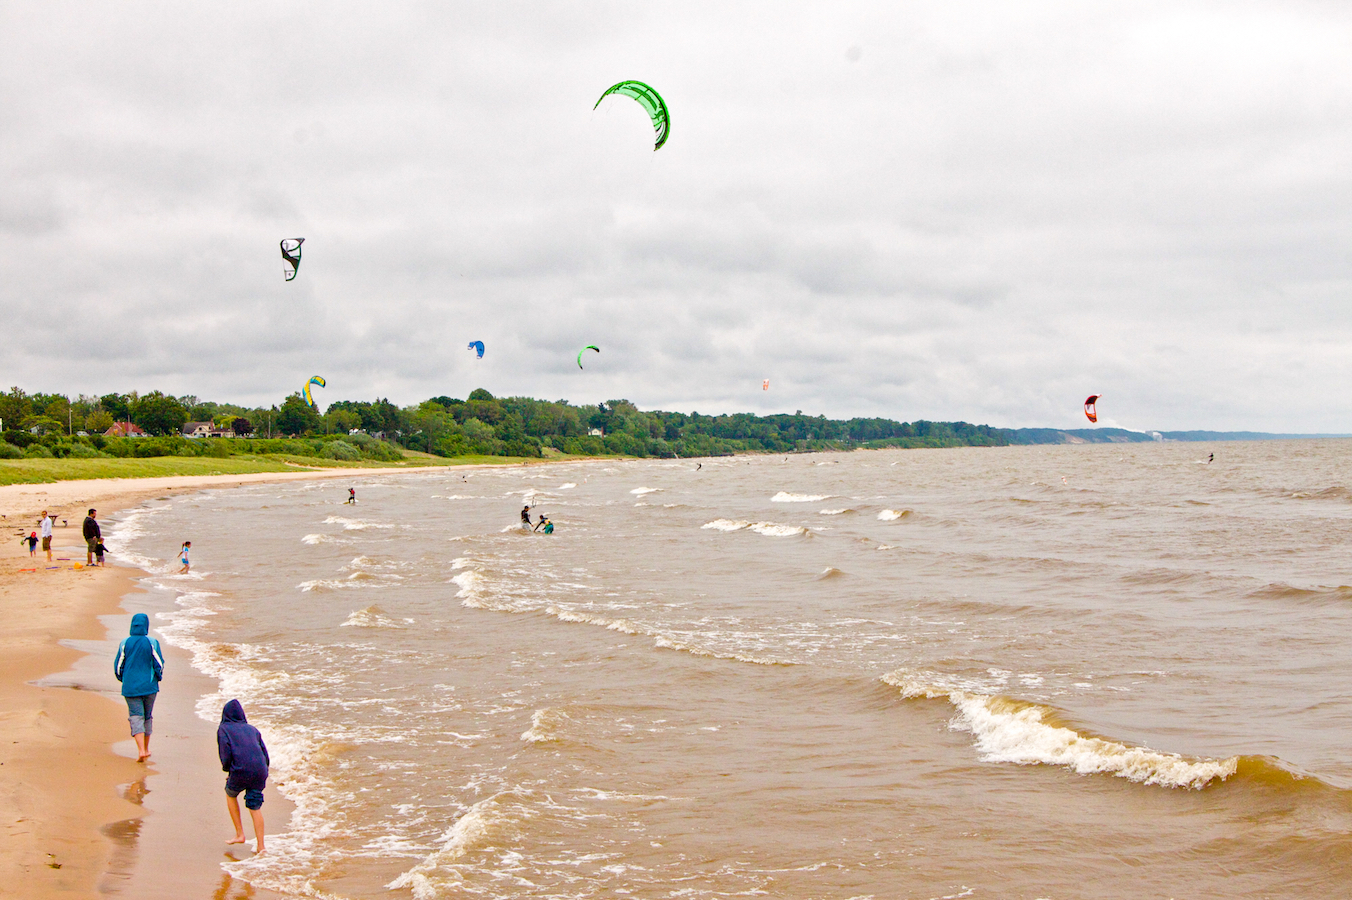

In [34]:
#@title Supply a path to download an image
IMAGE_PATH = "https://github.com/tensorflow/models/raw/master/research/object_detection/test_images/image2.jpg" #@param {type:"string"}

!wget -q -O image.png $IMAGE_PATH
Image.open('image.png')

In [84]:
#@title Inference utils
def display_results(image_path, interpreter, threshold=0.3):
    # Load the input image and preprocess it
    preprocessed_image, original_image = preprocess_image(image_path)

    # =============Perform inference=====================
    start_time = time.monotonic()
    results = detect_objects(interpreter, preprocessed_image, threshold=threshold)
    print(f"Elapsed time: {(time.monotonic() - start_time)*1000} miliseconds")

    # =============Display the results====================
    original_numpy = original_image.numpy()
    if "uint8" in tflite_model:
        original_numpy = (original_numpy+1.0)*127.5
        original_numpy = np.clip(original_numpy, 0, 255).astype(np.uint8)
    
    for obj in results:
        # Convert the bounding box figures from relative coordinates
        # to absolute coordinates based on the original resolution
        ymin, xmin, ymax, xmax = obj['bounding_box']
        xmin = int(xmin * original_numpy.shape[1])
        xmax = int(xmax * original_numpy.shape[1])
        ymin = int(ymin * original_numpy.shape[0])
        ymax = int(ymax * original_numpy.shape[0])

        # Grab the class index for the current iteration
        idx = int(obj['class_id'])
        # Skip the background
        if idx >= len(LABELS):
            continue

        # draw the bounding box and label on the image
        color = [int(c) for c in COLORS[idx]]
        cv2.rectangle(original_numpy, (xmin, ymin), (xmax, ymax), 
                    color, 2)
        y = ymin - 15 if ymin - 15 > 15 else ymin + 15
        label = "{}: {:.2f}%".format(LABELS[obj['class_id']],
            obj['score'] * 100)
        cv2.putText(original_numpy, label, (xmin, y),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # return the final image
    if "uint8" not in tflite_model:
        original_numpy = (original_numpy * 255).astype(np.uint8)
    return original_numpy

Elapsed time: 158.72478799974488 miliseconds


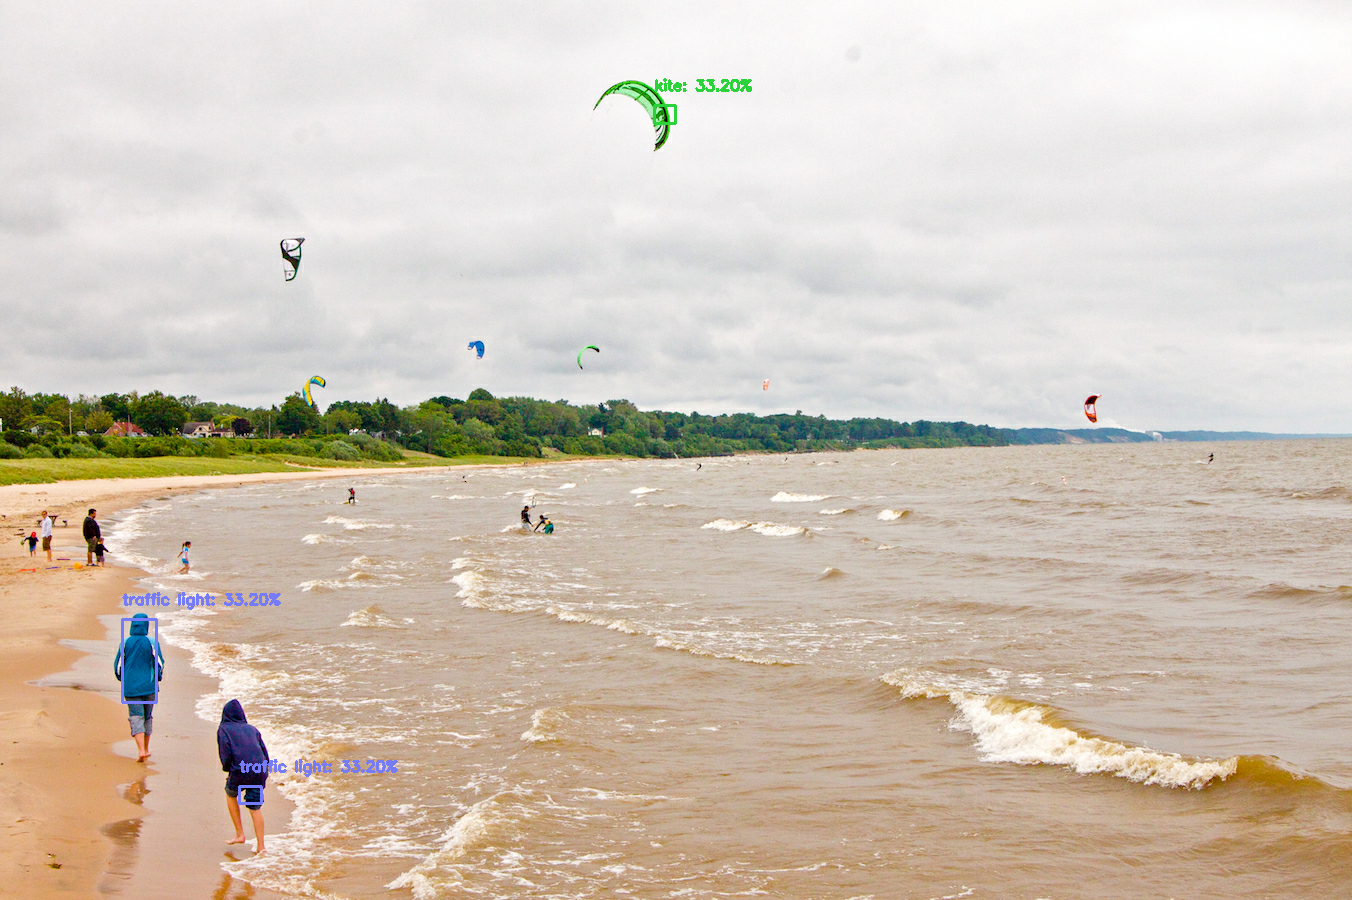

In [87]:
# Preprocess image and perform inference
resultant_image = display_results("image.png", interpreter, threshold=0.3)
Image.fromarray(resultant_image)

[This example](https://github.com/tensorflow/examples/blob/master/lite/examples/object_detection/raspberry_pi) provides a utility for running a similar TFLite model on real-time video feeds. For real use-cases you'd want to play with the `threshold` parameter. 